<a href="https://www.kaggle.com/code/heyrobin/credit-card-fraud-analysis?scriptVersionId=98309734" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from IPython.core.display import HTML; import urllib.request

def apply_styling_changes():
    get_url= urllib.request.urlopen('https://raw.githubusercontent.com/heyrobin/heyrobin-personalization/main/theme.css').read().decode("utf-8")
    return HTML("<style>"+get_url+"</style>")
apply_styling_changes()

<div class="page-title">Credit Card Fraud Analysis</div>
<div class="page-summary "> analysis on credit frauds.</div>

   
<img src="https://i.ibb.co/9mPwvKZ/1936a278707545.png"></center>

<div class="mini-bio-cred">Image Source : <a href="https://www.behance.net/gallery/78707545/Payment-Fraud-Protection?tracking_source=search_projects_recommended%7Ccredit%20card%20fraud" rel=" noreferrer nofollow">@Behance</a></div>

In [2]:
'''Libraries'''
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

'''DataSet'''
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<div class="page-title2 "> Missing Values </div>

In [4]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

We found no missing values from the data which is a good news for further exploration and modeling


<div class="page-title2 "> 1 | Imbalanced Data </div>

Imbalanced data refers to those types of datasets where the target class has an uneven distribution of observations, i.e one class label has a very high number of observations and the other has a very low number of observations. </br>Imbalance data will cause overfitting and lots of errors in algo.

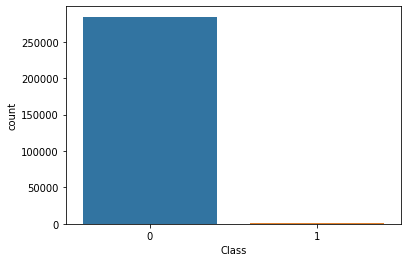

In [5]:
sns.countplot(df["Class"]);

Woah! there is very large diffrence between the class 0 and 1. It is an Imbalanced dataset<br>

<div class="page-title2 "> 2 | Scaling Features </div>

After understanding the features of the data we saw that all the `V features` are scaled but the time and amount isnt. To create the completed scaled data for the independent features we will have to scale `Time` and `Amount`.

In [6]:
# scaling the non scaled features

from sklearn.preprocessing import RobustScaler

rob_scale = RobustScaler()

df['scaled_amount']=rob_scale.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_Time']=rob_scale.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Amount','Time'], axis=1,inplace=True)

<div class="page-title2 "> 3 | Undersampling Technique </div>

Undersampling is a technique to balance uneven datasets by keeping all of the data in the minority class and decreasing the size of the majority class. It is one of several techniques data scientists can use to extract more accurate information from originally imbalanced datasets.

In [7]:
legit = df[df["Class"] == 0]
fraud = df[df["Class"] == 1]


print(f'Legit: {fraud.Class.value_counts()[1]} & Fraud : {legit.Class.value_counts()[0]}')

Legit: 492 & Fraud : 284315


In [8]:
ls = legit.sample(n=492)
ls.Class.value_counts()

0    492
Name: Class, dtype: int64

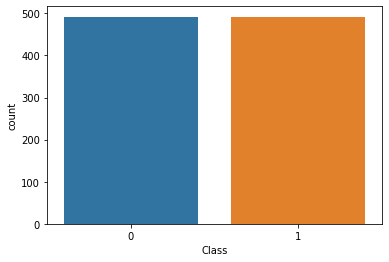

In [9]:
df2 = pd.concat([fraud,ls], axis = 0)
sns.countplot(df2["Class"]);

The class has been balanced by equal values. Lets perform modeling on this new balanced data

<div class="page-title2 "> 4 | Features Correlation </div>

Correlation is a table that shows the relation between 2 features. It helps to understand data more deeply. With colors and heatmap chart it helps you to visualize and spot difference very efficiently.

**Correlation**
* We are going to correlate imbalanced data and balanced data
* We will also look at the best features we get after correlation

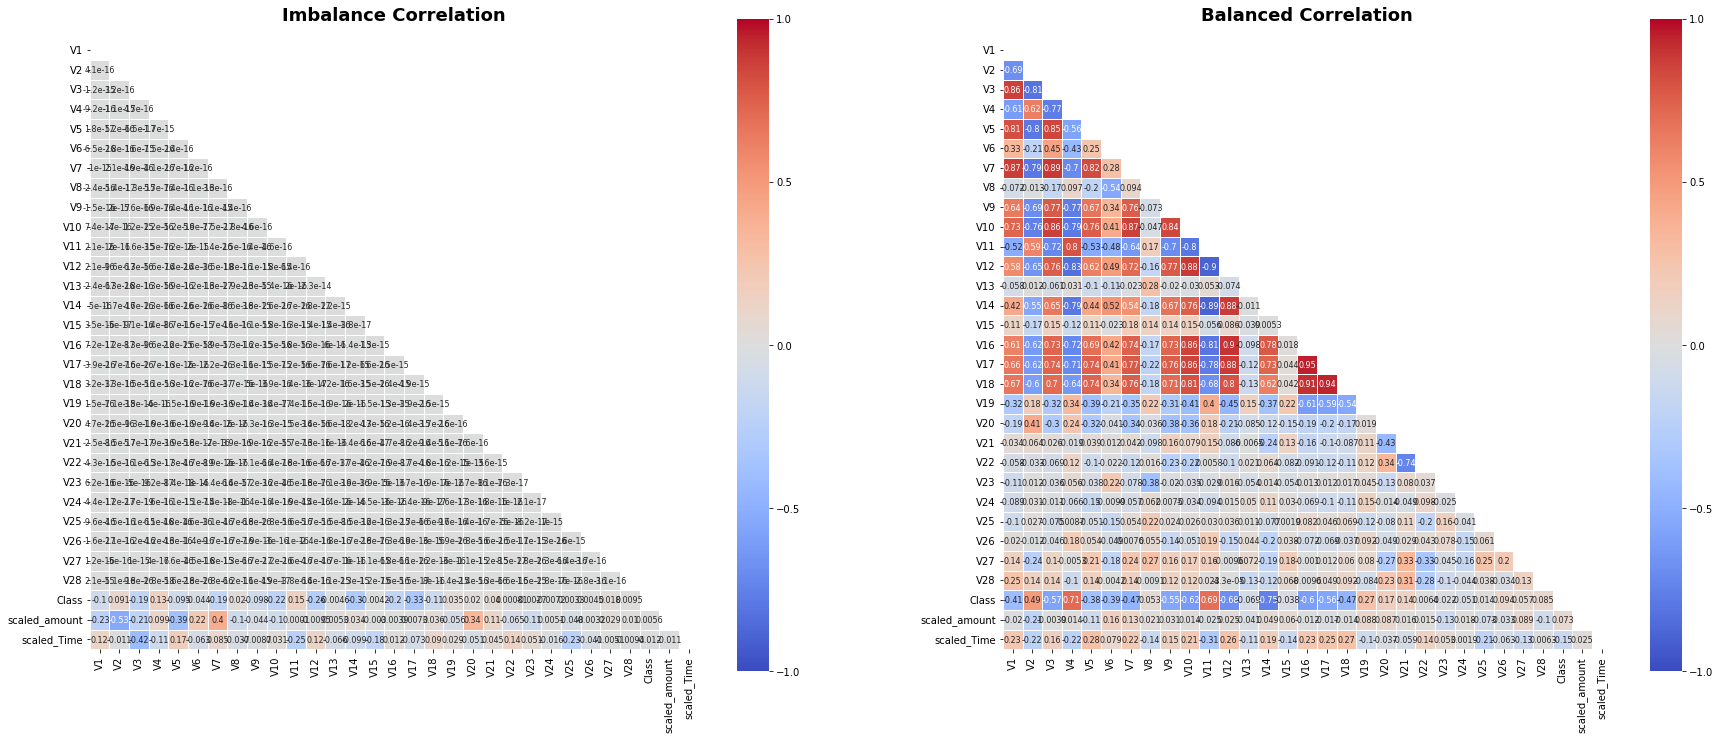

In [10]:
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)]= True


f, axes = plt.subplots(ncols=2, figsize=(30,30))

heatmap = sns.heatmap(df.corr(),
            mask = mask,
            square = True,
            linewidths = .5,
            cmap = 'coolwarm',
            cbar_kws = {'shrink': .4,"ticks" : [-1, -.5, 0, 0.5, 1]},
            vmin = -1,
            vmax = 1,
            annot = True,
            annot_kws = {"size": 8},
            ax = axes[0])

axes[0].set_title('Imbalance Correlation', size = 18, weight='bold', pad=20);

heatmap = sns.heatmap(df2.corr(),
            mask = mask,
            square = True,
            linewidths = .5,
            cmap = 'coolwarm',
            cbar_kws = {'shrink': .4,"ticks" : [-1, -.5, 0, 0.5, 1]},
            vmin = -1,
            vmax = 1,
            annot = True,
            annot_kws = {"size": 8},
            ax = axes[1])

axes[1].set_title('Balanced Correlation', size = 18, weight='bold', pad=20);

<blockquote><b>📌 Summary:</b>
<ul>
    <li> <code>Positively Correlated:</code>  V2, V4, V11,and V19 are <em>positively correlated</em> with class.</li>
    <li> <code>Negetively Correlated:</code> V3, V7, V10, V12, V14, V17 are <em>negetively correlated</em> with class.</li>
    </ul>
</blockquote>

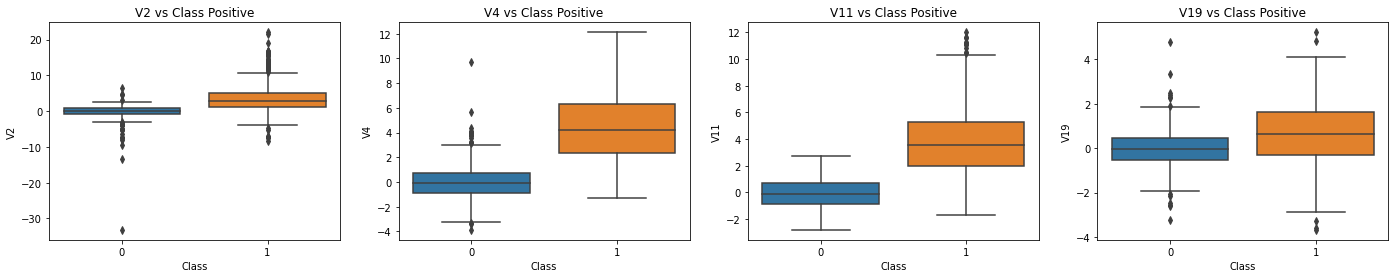

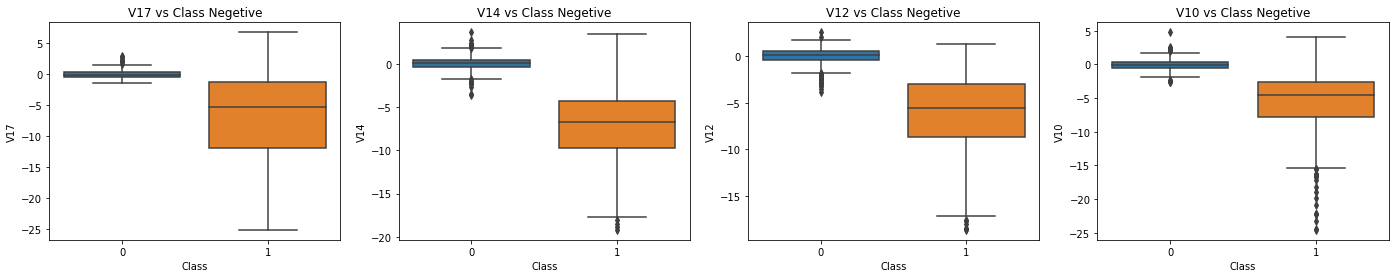

In [11]:
f, axes = plt.subplots(ncols=4, figsize=(24,4))

sns.boxplot(data=df2, x="Class", y="V2", ax=axes[0])
axes[0].set_title("V2 vs Class Positive")

sns.boxplot(data=df2, x="Class", y="V4", ax=axes[1])
axes[1].set_title("V4 vs Class Positive")

sns.boxplot(data=df2, x="Class", y="V11", ax=axes[2])
axes[2].set_title("V11 vs Class Positive")

sns.boxplot(data=df2, x="Class", y="V19", ax=axes[3])
axes[3].set_title("V19 vs Class Positive");


f, axes = plt.subplots(ncols=4, figsize=(24,4))

sns.boxplot(data=df2, x="Class", y="V17", ax=axes[0])
axes[0].set_title("V17 vs Class Negetive")

sns.boxplot(data=df2, x="Class", y="V14", ax=axes[1])
axes[1].set_title("V14 vs Class Negetive")

sns.boxplot(data=df2, x="Class", y="V12", ax=axes[2])
axes[2].set_title("V12 vs Class Negetive")

sns.boxplot(data=df2, x="Class", y="V10", ax=axes[3])
axes[3].set_title("V10 vs Class Negetive");



<div class="page-title2 "> Model Building </div>

We already balanced the data now we will train on the model

In [12]:
#spliting the data for target and features
X = df2.drop(columns='Class', axis=1)
y = df2['Class']

In [13]:
#creating the test train split
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state = 42)

In [14]:
models = {
    "LogisiticRegression": LogisticRegression(solver='liblinear'),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [15]:
from sklearn.model_selection import cross_val_score


def training_model():
    
    for key, model in models.items():
        model.fit(X_train,y_train)
        cv_score = cross_val_score(model,X_train,y_train,cv=5)
        print("Classifiers: ", key, "Has a training score of", round(cv_score.mean(), 2) * 100, "% accuracy score")
        
training_model()

Classifiers:  LogisiticRegression Has a training score of 94.0 % accuracy score
Classifiers:  KNearest Has a training score of 93.0 % accuracy score
Classifiers:  Support Vector Classifier Has a training score of 93.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 88.0 % accuracy score


<blockquote><b>📌 Summary:</b>
<ul>
    <li> Now We have trained the model with the balanced dataset and the accuracy is around <code>95%</code> for this model.</li>
    <li> the <code>f1 score</code> is <code>95%</code> and <code>94%</code> for both classes which is very fit but can we improve the model further for good accuracy?</li>
    </ul>
</blockquote>

<hr>
<div class="mini-bio" style="font-size:18px;">Thanks for reading share your feedback and leave an upvote if you liked the notebook.</div>
<br>
